In [31]:
import matplotlib.pyplot as plt
import readsnapGadget2 as snap
import numpy as np
import pickle
from copy import copy
from tqdm.notebook import tqdm

In [2]:
# read the simulation result
snapnum = 95
filename = f"data/snapshot_{str(snapnum).zfill(3)}"
head = snap.snapshot_header(filename) # read the header

# read list of particle positions
pos = snap.read_block(filename, "POS ")

# create copy of particle locations. It stores the locations of particles that have not been grouped yet.
particles = pos.copy()

# list of particle masses
mass = snap.read_block(filename, "MASS")
n_particles = len(pos)

# linking length for friends of friends algo
boxsize = head.boxsize # you will see later that this is what the header gives
link_len = 0.2*(boxsize**3/n_particles)**(1/3) #kpc formula: 0.2*(V/N)^(1/3) N = 262144 will check it later

#check necessary quantities
assert head.redshift < 1e-10
assert head.boxsize == 50000

In [3]:
print(f"The total number of particles is {n_particles}")

The total number of particles is 262144


In [4]:
# This calculates the 3d distance between the selected particle and all the other particles that have not been grouped
def distance(other_particles, particle):
    # get the differece in x, y, z coordinates
    dx = other_particles[:, 0] - particle[0]
    dy = other_particles[:, 1] - particle[1]
    dz = other_particles[:, 2] - particle[2]
    # account for periodic boundary conditions
    dx[dx > boxsize/2] = boxsize - dx[dx > boxsize/2]
    dy[dy > boxsize/2] = boxsize - dy[dy > boxsize/2]
    dz[dz > boxsize/2] = boxsize - dz[dz > boxsize/2]
    
    dist = (dx**2 + dy**2 + dz**2)**0.5
    return dist

In [5]:
groups = {} # Positions of halo particles
sizes = {} # size of the halo (# of particles in it)
group_id = 0 #initial group id
pbar = tqdm(total = len(particles)) #progress bar

while len(particles) > 0:
    part = particles[0] #location of first particle
    dists = distance(particles, part)
    
    # add close-enough particles to the current group, and remove them
    mask = np.where(dists < link_len)[0]
    groups[group_id] = particles[mask]
    particles = np.delete(particles, mask, axis=0)
    
    '''Find the friends of friends of part'''
    pointer = 1 # for whom we are looking for more friends? the index of elements ingroups[group_id])
    num_friends = len(groups[group_id])
    while pointer < num_friends:
        
        # get position and distances of the friend being considered, and which are close enough
        part_friend = groups[group_id][pointer]
        dists = distance(particles, part_friend)
        mask = np.where(dists < link_len)[0]
        
        # if we found friends of that friend, add to current group and delete from particle list
        if len(mask) > 0:
            friends_of_friend = particles[mask]
            groups[group_id] = np.concatenate([groups[group_id], friends_of_friend])
            particles = np.delete(particles, mask, axis=0)

        pointer +=1
    
    '''Current group completed. Move on to the next group'''
    sizes[group_id] = len(groups[group_id]) 
    group_id += 1
    pbar.update(1)

KeyboardInterrupt: 

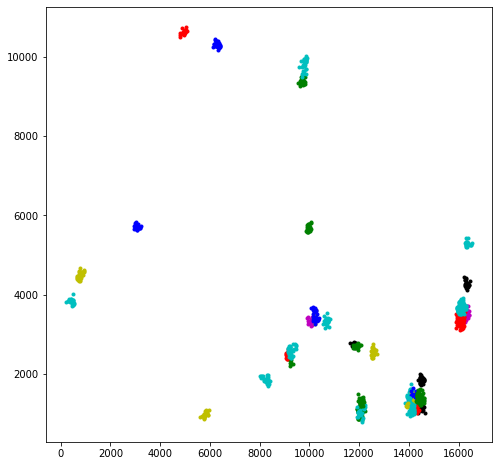

In [7]:
# Try to plot halos (2d projection) but takes lots of time to run. There has to be a better way of doing this

colorlist = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(8,8))
for i in range(group_id):
    if sizes[i]>20:
        for j in range(sizes[i]):
            plt.plot(groups[i][j][0], groups[i][j][1], '.', color=colorlist[i%7])
plt.xlim(0, boxsize)
plt.ylim(0, boxsize)
plt.grid()

In [30]:
groupsize_max = int(np.amax(np.fromiter(sizes.values(), dtype=float)))
biggest_halo_mass = groupsize_max*mass[0]
print(f"The largest halo (of {group_id}) has a mass of {biggest_halo_mass} x 10^10 solar masses.")
assert len(set(mass)) == 1

The largest halo (of 142572) has a mass of 1461.4984729290009 x 10^10 solar masses.


In [32]:
pickle.dump(groups, open( "groups.pickle", "wb"))
pickle.dump(sizes, open("sizes.pickle", "wb"))

In [33]:
# examples of how to load them
groups_load = pickle.load(open( "groups.pickle", "rb" ))
sizes_load = pickle.load(open( "sizes.pickle", "rb" ))